In [1]:
import os
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import joblib
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import feature_column as fc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import preprocessing
from sklearn.utils import shuffle
from tensorflow.keras.models import save_model,load_model

from utils.util import *
from utils.preprocessing import *
from utils.dataiter import Dataiter
from utils.evaluate import calculate_ctr, compute_rce, average_precision_score
from utils.target_encode import MTE_one_shot

import tensorflow.keras.backend as K
import core.config as conf

## Load data

In [2]:
path = f'{conf.raw_lzo_path}/part-00000'
train = read_data(path)

In [3]:
TARGET = 'like'

- media target encoding(photo, video, gif)
- tweet_type
- language
- tweet_timestamp
- engaged_with_user_id
- engaged_with_user_follower_count
- engaging_user_id
- engaging_user_following_count
- engagee_follows_engager
- 'reply_timestamp', 'retweet_timestamp','retweet_with_comment_timestamp', 'like_timestamp'

## Preprocessing

In [4]:
def set_dataframe_types(df, train):
    df['id']   = np.arange( df.shape[0] )
    df['id']   = df['id'].astype(np.uint32)

    if train:
        df['reply_timestamp']   = df['reply_timestamp'].fillna(0)
        df['retweet_timestamp'] = df['retweet_timestamp'].fillna(0)
        df['comment_timestamp'] = df['comment_timestamp'].fillna(0)
        df['like_timestamp']    = df['like_timestamp'].fillna(0)

        df['reply_timestamp']   = df['reply_timestamp'].astype(np.uint32)
        df['retweet_timestamp'] = df['retweet_timestamp'].astype(np.uint32)
        df['comment_timestamp'] = df['comment_timestamp'].astype(np.uint32)
        df['like_timestamp']    = df['like_timestamp'].astype(np.uint32)

    df['tweet_timestamp']         = df['tweet_timestamp'].astype( np.uint32 )
    df['creator_follower_count']  = df['creator_follower_count'].astype( np.uint32 )
    df['creator_following_count'] = df['creator_following_count'].astype( np.uint32 )
    df['creator_account_creation']= df['creator_account_creation'].astype( np.uint32 )
    df['engager_follower_count']  = df['engager_follower_count'].astype( np.uint32 )
    df['engager_following_count'] = df['engager_following_count'].astype( np.uint32 )
    df['engager_account_creation']= df['engager_account_creation'].astype( np.uint32 )

    return df


def preprocess(df, target, train):
    df = set_dataframe_types(df, train)
    # df = df.set_index('id')
    # df.columns = conf.raw_features + conf.labels
    df = df.drop('text_tokens', axis=1)
    
    df = feature_extraction(df, features=conf.used_features, train=train) # extract 'used_features'
    cols = []

    return df

In [5]:

train = preprocess(train, TARGET, True)


In [6]:
train

,engager_is_verified,domains,language,creator_is_verified,creator_account_creation,engager_follower_count,tweet_type,engager_id,creator_follower_count,creator_following_count,...,engager_account_creation,tweet_id,reply,retweet,comment,like,dt_day,dt_dow,dt_hour,len_domains
0,0,0,19,0,1261859734,169,1,2AEB7AFFD36CA43C0C963F24F75BCCAC,2473,662,...,1520886748,5DCE3020423313CB0AC2631DEF94D2F5,0.0,0.0,0.0,0.0,13,5,17,0
1,0,1,46,1,1266804490,393,2,865C52D28FA84E5E233B530C6FDAECC2,4418640,228,...,1237570695,2B6F5C7C4F04F34543C09DD6E58C8F66,0.0,0.0,0.0,0.0,19,4,15,1
2,0,2,46,1,1202617218,629,2,FE83E568BD4B2ACDBAF876CFBB6C7296,219715,3685,...,1263176351,784D3AE5E6429392245BD34FF4C82B5C,0.0,0.0,0.0,1.0,15,0,10,1
3,0,0,46,1,1251645191,123,1,DB0201BF93E4CCA1B55932AC36923E43,2388283,13511,...,1268276559,CA49ACBB31921F2A0FAC1CCCC99541F6,0.0,0.0,0.0,0.0,19,4,4,0
4,0,0,61,0,1578273274,134,2,04F45C4A769FE2D7C792A96C92342DC2,414,720,...,1483862063,2C95B42C651B36D84584F3653D722142,0.0,0.0,0.0,1.0,6,5,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3033897,0,0,48,0,1562591414,254,1,AB51B05ACD422823A8567E51D106FBCF,2230,2332,...,1505241576,25B1D557E6B6D7298CA3888C72F9F7B5,0.0,0.0,0.0,0.0,8,0,17,0
3033898,0,0,19,0,1591895377,238,2,2F0B0497A2C1F6DBF120782E915B1F63,90842,687,...,1587168543,3A656480D09FCCBA39B0E28FBFA64B72,1.0,0.0,0.0,0.0,22,0,3,0
3033899,0,0,19,0,1341523778,814,1,5FFAD564CE93396A11C7951AA07D019E,608,328,...,1336720553,E236B2359B119B2A7668FA83AC5E750B,0.0,0.0,0.0,0.0,23,1,23,0
3033900,0,0,46,1,1263785737,27,2,1C3C0C32D7AEBCA253DC54EC85084951,6777417,888,...,1540658011,B42CB5B47ABCCA8700686CD8F32696B6,0.0,0.0,0.0,1.0,14,6,19,0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3033902 entries, 0 to 3033901
Data columns (total 25 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   engager_is_verified       int8   
 1   domains                   int32  
 2   language                  uint8  
 3   creator_is_verified       int8   
 4   creator_account_creation  int32  
 5   engager_follower_count    int32  
 6   tweet_type                uint8  
 7   engager_id                object 
 8   creator_follower_count    int32  
 9   creator_following_count   int32  
 10  tweet_timestamp           int32  
 11  creator_follows_engager   int8   
 12  engager_following_count   int32  
 13  media                     uint8  
 14  creator_id                object 
 15  engager_account_creation  int32  
 16  tweet_id                  object 
 17  reply                     float32
 18  retweet                   float32
 19  comment                   float32
 20  like                    

### Negative Sampling

In [8]:
df_positive = train[train['like']==1]
df_negative = train[train['like']==0]
print(len(df_positive))
print(len(df_negative))

1207588
1826314


In [9]:
df_negative = df_negative.sample(n = len(df_positive), random_state=777)

In [10]:
train = pd.concat([df_positive, df_negative])

In [11]:
train  = train.sample(frac = 1)

In [12]:
train.head()

,engager_is_verified,domains,language,creator_is_verified,creator_account_creation,engager_follower_count,tweet_type,engager_id,creator_follower_count,creator_following_count,...,engager_account_creation,tweet_id,reply,retweet,comment,like,dt_day,dt_dow,dt_hour,len_domains
2593570,0,0,19,0,1334310089,1178,1,B40A2B0E886CFD4358704D28593C9C25,947,838,...,1566917103,581380BC9517F3158DA3C579A5F25901,0.0,0.0,0.0,0.0,9,1,0,0
632669,0,0,41,0,1333031651,465,2,05A3855B134C0648C65551B37F615F2A,2802,2529,...,1545463831,CE73DE68CBD2B8DCAFFC34DF6B532145,0.0,0.0,0.0,1.0,5,4,15,0
3022303,0,0,61,0,1505838423,4549,1,23F5BF47BFF0C93475D49CD1FA26D441,445,750,...,1472520367,62A4F63F7A8C3D6CF7340A7DC165806C,0.0,0.0,0.0,1.0,16,1,16,0
1574967,0,0,19,0,1374700901,1147,2,EA6FFF8A25890DC2F6C0AB14888635BA,87,510,...,1354480427,16F02A45A298F342BD0088482E84F931,0.0,0.0,0.0,1.0,16,1,6,0
1483368,0,0,19,0,1500422791,238,2,E4F7246CFF91D4B85B1778329CD136F3,148,327,...,1589664143,1022DDB4253F9AB20A410071617FEA6B,0.0,0.0,0.0,0.0,11,3,3,0


## Modeling

In [13]:
label_names = ['reply', 'retweet', 'comment']
DONT_USE = ['tweet_timestamp', 'engager_account_creation','engage_time',
            'engager_account_creation',
            'fold','tweet_id', 
            'tr','dt_day','','',
            'creator_id', 'engager_id','engager_is_verified',
            'elapsed_time',
            'links','domains','hashtags0','hashtags1',
            'hashtags','tweet_hash','dt_second','id',
            'tw_hash0',
            'tw_hash1',
            'tw_rt_uhash',
            'same_language', 'nan_language',
            'tw_hash', 'tw_freq_hash','tw_first_word', 'tw_second_word', 'tw_last_word', 'tw_llast_word',
            'ypred','creator_count_combined','creator_user_fer_count_delta_time','creator_user_fing_count_delta_time','creator_user_fering_count_delta_time','creator_user_fing_count_mode','creator_user_fer_count_mode','creator_user_fering_count_mode'
           ]
DONT_USE += label_names
DONT_USE += conf.labels


In [14]:
RMV = [c for c in DONT_USE if c in train.columns]

### Data Split

In [15]:
#y_train = train[TARGET]
train = train.drop(RMV, axis=1)

In [16]:
train, test = train_test_split(train, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

In [17]:
train

,language,creator_is_verified,creator_account_creation,engager_follower_count,tweet_type,creator_follower_count,creator_following_count,creator_follows_engager,engager_following_count,media,like,dt_dow,dt_hour,len_domains
598424,60,0,1522582506,337,1,185,322,1,393,0,1.0,1,9,0
1796363,61,0,1526102153,174,0,26729,5001,0,494,0,0.0,1,14,0
1638506,19,0,1555707668,8,2,8841,247,0,177,0,1.0,6,15,1
1705337,19,1,1244320594,27,2,952115,737,0,207,0,1.0,2,17,0
1511945,5,0,1524138405,280,2,522,449,1,253,0,1.0,3,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2900430,23,0,1495488298,3844,1,10663,9937,1,1223,0,0.0,6,17,0
1261063,61,0,1269476300,25,2,122420,95962,1,98,5,0.0,2,11,0
2302039,19,0,1455369086,362,1,354,413,1,334,0,0.0,5,11,0
2088670,19,0,1478536973,600,1,3893,2204,0,1004,7,0.0,3,11,0


### Scaling

In [18]:
columns = ['creator_account_creation', 'engager_follower_count', 'engager_following_count', 'creator_follower_count', 'creator_following_count']

In [19]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
val = val.reset_index(drop=True)

In [20]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(train[columns])

StandardScaler()

In [21]:
ss = standard_scaler.transform(train[columns])

In [22]:
std_std = pd.DataFrame(ss, columns=columns)

In [23]:
train[columns] = std_std

In [24]:
ss = standard_scaler.transform(val[columns])
std_val = pd.DataFrame(ss, columns = columns)

In [25]:
val[columns] = std_val

In [26]:
ss = standard_scaler.transform(test[columns])
std_test = pd.DataFrame(ss, columns = columns)

In [27]:
test[columns] = std_test

### Model

In [28]:
def get_quantile_based_boundaries(feature_values, num_buckets):
    boundaries = np.arange(1.0, num_buckets) / num_buckets
    quantiles = feature_values.quantile(boundaries)
    return sorted([quantiles[q] for q in quantiles.keys()])

In [29]:
def construct_feature_columns():
    feature_columns = []
    feature_layer_inputs={}
    
    creator_follower_count = tf.feature_column.numeric_column("creator_follower_count")
    creator_account_creation = tf.feature_column.numeric_column("creator_account_creation")
    
    for header in ['language', 'creator_account_creation', 'creator_following_count', 'creator_follower_count', 'engager_following_count', 
                   'engager_follower_count', 'media', 'tweet_type', 'creator_is_verified', 'creator_follows_engager', 'dt_dow', 'dt_hour', 'len_domains']:
        feature_columns.append(tf.feature_column.numeric_column(header))
        feature_layer_inputs[header] = tf.keras.Input(shape=(1,), name=header)
    
    creator_id = tf.feature_column.embedding_column('creator_id', dimension=8)

    bucketized_creator_follower_count = tf.feature_column.bucketized_column(
        creator_follower_count, boundaries=get_quantile_based_boundaries(
            train["creator_follower_count"], 10))
    feature_columns.append(bucketized_creator_follower_count)
    
    bucketized_creator_account_creation = tf.feature_column.bucketized_column(
        creator_account_creation, boundaries=get_quantile_based_boundaries(
            train["creator_account_creation"], 10))
    feature_columns.append(bucketized_creator_account_creation)
    
    
    creator_follower_x_account = tf.feature_column.crossed_column(
        set([bucketized_creator_follower_count, bucketized_creator_account_creation]), hash_bucket_size=1000)
    creator_follower_x_account = tf.feature_column.indicator_column(creator_follower_x_account)
    feature_columns.append(creator_follower_x_account)
    

    #feature_layer_inputs['bucketized_creator_account_creation'] = tf.keras.Input(shape=(1,), name='bucketized_creator_account_creation')

    #feature_layer_inputs['creator_follower_x_account'] = tf.keras.Input(shape=(1,), name='creator_follower_x_account')
    
    return feature_columns, feature_layer_inputs

In [30]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('like')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size, drop_remainder=True)
    return ds

In [31]:
ds_train = df_to_dataset(train)
ds_val = df_to_dataset(val, shuffle=False)
ds_test = df_to_dataset(test, shuffle=False)

In [32]:
feature_columns, feature_layer_inputs = construct_feature_columns()

In [33]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [34]:
feature_layer_output = feature_layer(feature_layer_inputs)

In [35]:
input = [v for v in feature_layer_inputs.values()]

In [36]:
x = Dense(16, activation="relu")(feature_layer_output)
x = Dense(8, activation="relu")(x)
x = Dense(4, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)

In [37]:
model = tf.keras.Model(inputs=input, outputs=outputs, name="sequential_model")

In [38]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy', # softmax : sparse_categorical_crossentropy, sigmoid : binary_crossentropy
    metrics=['binary_crossentropy']) # sigmoid :binary_crossentropy

In [39]:
ds_train

<BatchDataset shapes: ({language: (32,), creator_is_verified: (32,), creator_account_creation: (32,), engager_follower_count: (32,), tweet_type: (32,), creator_follower_count: (32,), creator_following_count: (32,), creator_follows_engager: (32,), engager_following_count: (32,), media: (32,), dt_dow: (32,), dt_hour: (32,), len_domains: (32,)}, (32,)), types: ({language: tf.uint8, creator_is_verified: tf.int8, creator_account_creation: tf.float64, engager_follower_count: tf.float64, tweet_type: tf.uint8, creator_follower_count: tf.float64, creator_following_count: tf.float64, creator_follows_engager: tf.int8, engager_following_count: tf.float64, media: tf.uint8, dt_dow: tf.int8, dt_hour: tf.int8, len_domains: tf.int64}, tf.float32)>

In [40]:
model.summary()

Model: "sequential_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
creator_account_creation (Input [(None, 1)]          0                                            
__________________________________________________________________________________________________
creator_follower_count (InputLa [(None, 1)]          0                                            
__________________________________________________________________________________________________
creator_following_count (InputL [(None, 1)]          0                                            
__________________________________________________________________________________________________
creator_follows_engager (InputL [(None, 1)]          0                                            
___________________________________________________________________________________

In [41]:
ds_train

<BatchDataset shapes: ({language: (32,), creator_is_verified: (32,), creator_account_creation: (32,), engager_follower_count: (32,), tweet_type: (32,), creator_follower_count: (32,), creator_following_count: (32,), creator_follows_engager: (32,), engager_following_count: (32,), media: (32,), dt_dow: (32,), dt_hour: (32,), len_domains: (32,)}, (32,)), types: ({language: tf.uint8, creator_is_verified: tf.int8, creator_account_creation: tf.float64, engager_follower_count: tf.float64, tweet_type: tf.uint8, creator_follower_count: tf.float64, creator_following_count: tf.float64, creator_follows_engager: tf.int8, engager_following_count: tf.float64, media: tf.uint8, dt_dow: tf.int8, dt_hour: tf.int8, len_domains: tf.int64}, tf.float32)>

In [42]:
history = model.fit(ds_train, epochs=2)

Epoch 1/2
48303/48303 [==============================] - 36s 668us/step - loss: 0.6555 - binary_crossentropy: 0.6555
Epoch 2/2
48303/48303 [==============================] - 44s 690us/step - loss: 0.6457 - binary_crossentropy: 0.6457


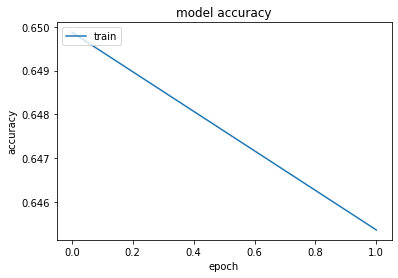

In [43]:
plt.plot(history.history['binary_crossentropy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [44]:
model.evaluate(ds_test)

15094/15094 [==============================] - 9s 565us/step - loss: 0.6441 - binary_crossentropy: 0.6441


[0.6440975666046143, 0.6440975666046143]

## Predict

In [45]:
y = np.concatenate([y for x, y in ds_test], axis=0)

In [46]:
pred = model.predict(ds_test)

In [47]:
pred

array([[0.38738298],
       [0.67565274],
       [0.74514955],
       ...,
       [0.5715013 ],
       [0.4784488 ],
       [0.5899271 ]], dtype=float32)

In [48]:
rce = compute_rce(pred, y)
rce

7.07591528648901

In [49]:
average_precision_score(y, pred)

0.6506027080888467

In [50]:
model.summary()

Model: "sequential_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
creator_account_creation (Input [(None, 1)]          0                                            
__________________________________________________________________________________________________
creator_follower_count (InputLa [(None, 1)]          0                                            
__________________________________________________________________________________________________
creator_following_count (InputL [(None, 1)]          0                                            
__________________________________________________________________________________________________
creator_follows_engager (InputL [(None, 1)]          0                                            
___________________________________________________________________________________

In [51]:
model_path = f'/hdd/cpu_models_DNN/model-ffnn.h5'
            
save_model(model, model_path)